In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
folder = 'MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
modalities = {
    'FLAIR': f'{folder}/BraTS20_Training_001_flair.nii',
    'T1': f'{folder}/BraTS20_Training_001_t1.nii',
    'T1c': f'{folder}/BraTS20_Training_001_t1ce.nii',
    'T2': f'{folder}/BraTS20_Training_001_t2.nii'
}

In [2]:
# Đọc và hiển thị thông tin từng file
images = {}
for key, path in modalities.items():
    img = nib.load(path)
    arr = img.get_fdata()
    images[key] = arr
    header = img.header
    print(f'{key}: shape={arr.shape}, dtype={arr.dtype}')
    print(f'  Min value: {arr.min():.2f}')
    print(f'  Max value: {arr.max():.2f}')
    print(f'  Mean value: {arr.mean():.2f}')
    print(f'  Voxel dimensions: {header.get_zooms()}')
    print('-'*40)

FLAIR: shape=(240, 240, 155), dtype=float64
  Min value: 0.00
  Max value: 625.00
  Mean value: 26.02
  Voxel dimensions: (np.float32(1.0), np.float32(1.0), np.float32(1.0))
----------------------------------------
T1: shape=(240, 240, 155), dtype=float64
  Min value: 0.00
  Max value: 678.00
  Mean value: 53.29
  Voxel dimensions: (np.float32(1.0), np.float32(1.0), np.float32(1.0))
----------------------------------------
T1c: shape=(240, 240, 155), dtype=float64
  Min value: 0.00
  Max value: 1845.00
  Mean value: 62.77
  Voxel dimensions: (np.float32(1.0), np.float32(1.0), np.float32(1.0))
----------------------------------------
T2: shape=(240, 240, 155), dtype=float64
  Min value: 0.00
  Max value: 376.00
  Mean value: 17.25
  Voxel dimensions: (np.float32(1.0), np.float32(1.0), np.float32(1.0))
----------------------------------------


In [3]:
seg_candidates = [f for f in os.listdir(folder) if 'seg' in f and (f.endswith('.nii') or f.endswith('.nii.gz'))]
seg_path = os.path.join(folder, seg_candidates[0]) if seg_candidates else None
label_names = {0: 'Background', 1: 'NCR/NET (Necrotic/Non-Enhancing Tumor)', 2: 'ED (Edema)', 4: 'ET (Enhancing Tumor)'}
if seg_path:
    seg_img = nib.load(seg_path)
    seg_arr = seg_img.get_fdata()
    unique_labels = np.unique(seg_arr)
    print(f'SEG: shape={seg_arr.shape}, dtype={seg_arr.dtype}, unique labels: {unique_labels}')
    print('Ý nghĩa các label:')
    for label in unique_labels:
        name = label_names.get(int(label), 'Unknown')
        print(f'  Label {int(label)}: {name}')
else:
    seg_arr = None
    print('Không tìm thấy file segmentation trong thư mục mẫu.')

SEG: shape=(240, 240, 155), dtype=float64, unique labels: [0. 1. 2. 4.]
Ý nghĩa các label:
  Label 0: Background
  Label 1: NCR/NET (Necrotic/Non-Enhancing Tumor)
  Label 2: ED (Edema)
  Label 4: ET (Enhancing Tumor)


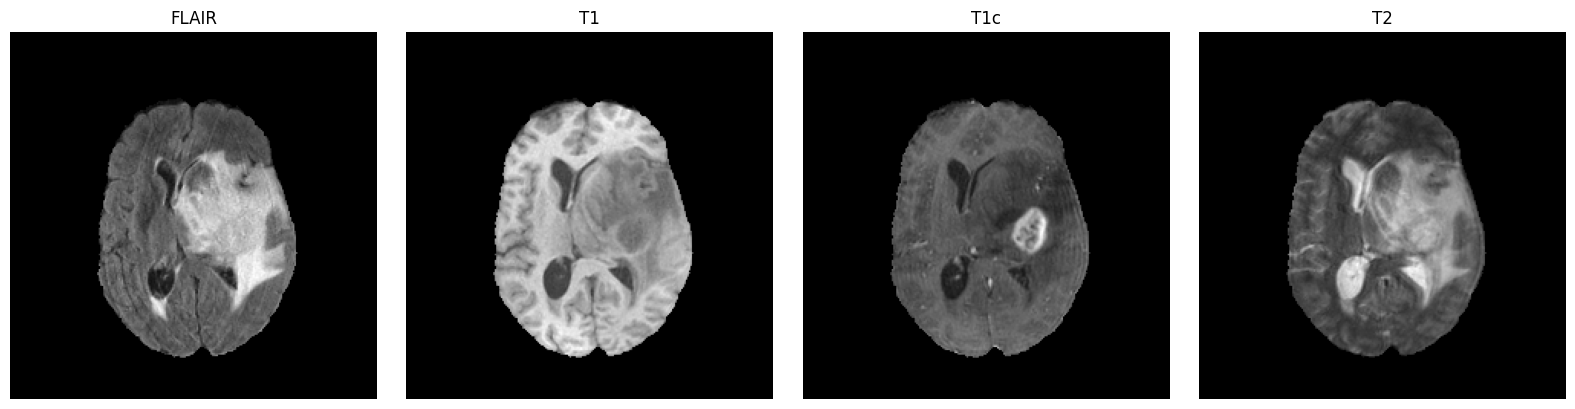

Đang hiển thị slice axial giữa: 77


In [4]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
modal_keys = ['FLAIR', 'T1', 'T1c', 'T2']
for i, key in enumerate(modal_keys):
    arr = images[key]
    axial_idx = arr.shape[2] // 2
    img_rot = np.rot90(arr[:, :, axial_idx].T, k=2)
    axes[i].imshow(img_rot, cmap='gray', origin='lower')
    axes[i].set_title(key)
    axes[i].axis('off')
plt.tight_layout()
plt.show()
print(f'Đang hiển thị slice axial giữa: {axial_idx}')

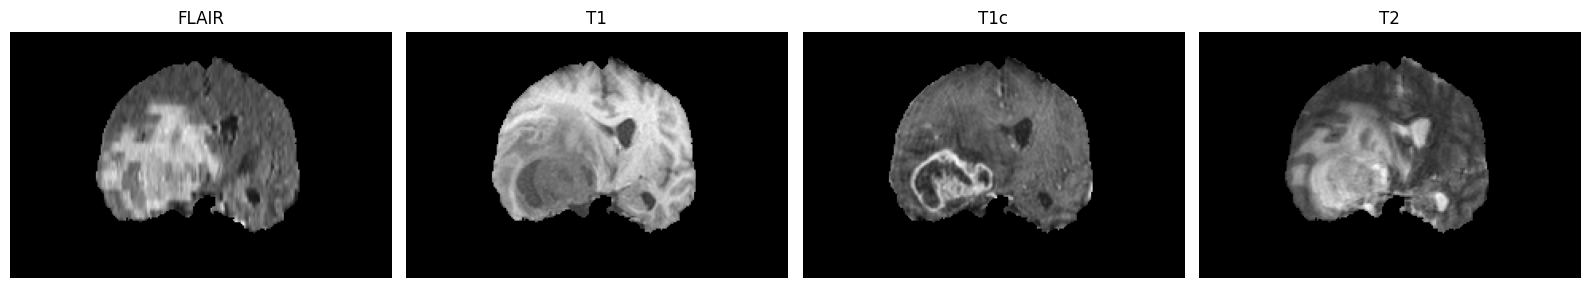

Đang hiển thị slice axial giữa: 120


In [5]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
modal_keys = ['FLAIR', 'T1', 'T1c', 'T2']
for i, key in enumerate(modal_keys):
    arr = images[key]
    coronal_idx = arr.shape[1] // 2
    axes[i].imshow(arr[:, coronal_idx, :].T, cmap='gray', origin='lower')
    axes[i].set_title(key)
    axes[i].axis('off')
plt.tight_layout()
plt.show()
print(f'Đang hiển thị slice axial giữa: {coronal_idx}')

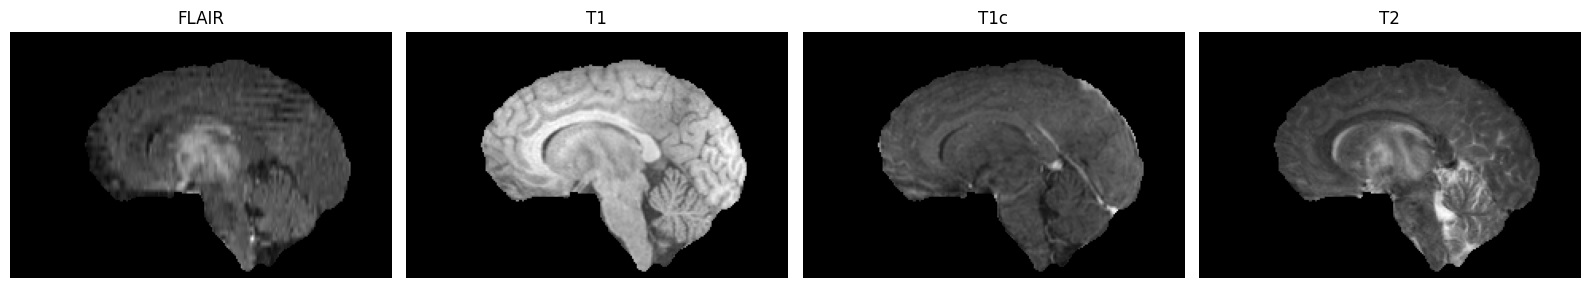

Đang hiển thị slice axial giữa: 120


In [6]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
modal_keys = ['FLAIR', 'T1', 'T1c', 'T2']
for i, key in enumerate(modal_keys):
    arr = images[key]
    sagittal_idx = arr.shape[0] // 2
    axes[i].imshow(arr[sagittal_idx, :, :].T, cmap='gray', origin='lower')
    axes[i].set_title(key)
    axes[i].axis('off')
plt.tight_layout()
plt.show()
print(f'Đang hiển thị slice axial giữa: {sagittal_idx}')

# ROI - extraction

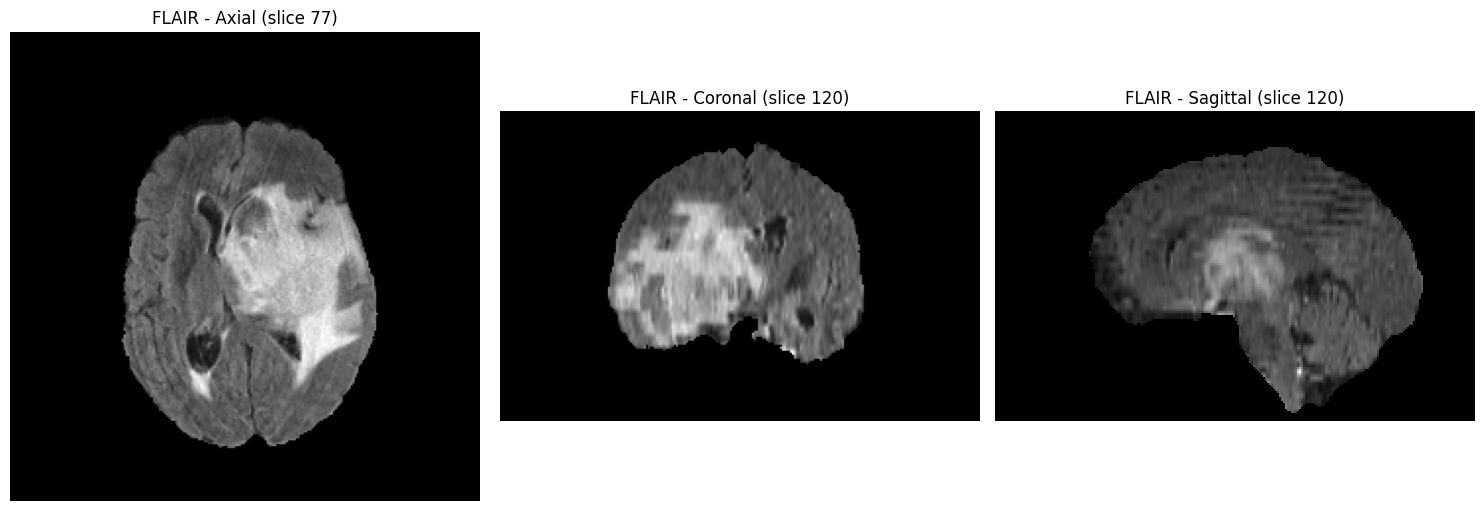

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial slice
axial_img = np.rot90(images['FLAIR'][:, :, axial_idx].T, k=2)
axes[0].imshow(axial_img, cmap='gray', origin='lower')
axes[0].set_title(f'FLAIR - Axial (slice {axial_idx})')
axes[0].axis('off')

# Coronal slice
coronal_img = np.rot90(images['FLAIR'][:, coronal_idx, :].T, k=4)
axes[1].imshow(coronal_img, cmap='gray', origin='lower')
axes[1].set_title(f'FLAIR - Coronal (slice {coronal_idx})')
axes[1].axis('off')

# Sagittal slice
sagittal_img = np.rot90(images['FLAIR'][sagittal_idx, :, :].T, k=4)
axes[2].imshow(sagittal_img, cmap='gray', origin='lower')
axes[2].set_title(f'FLAIR - Sagittal (slice {sagittal_idx})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [8]:
import sys
sys.path.append('../utils')  # hoặc đường dẫn tuyệt đối tới thư mục utils

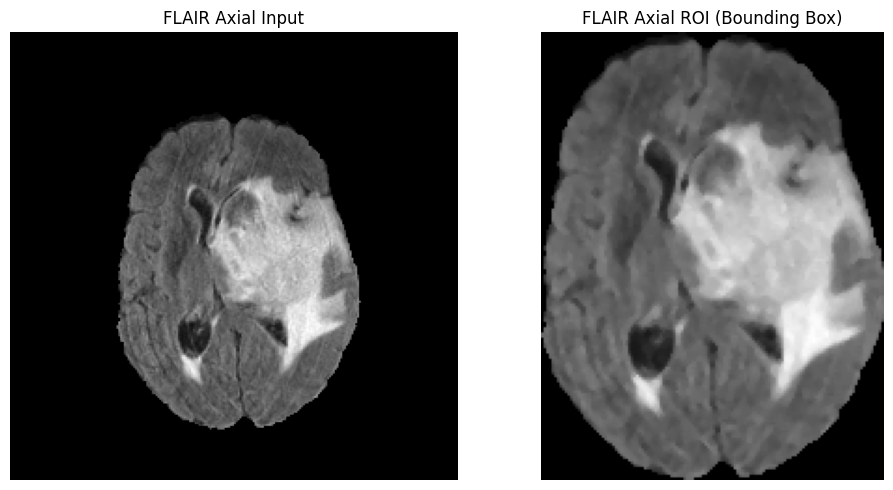

Đang hiển thị slice axial giữa: 77


In [9]:
# Sử dụng class ROI đã sửa để crop sát nhất với não (loại bỏ background thừa)
from roi_extract import ROI
import numpy as np
import matplotlib.pyplot as plt

arr = images['FLAIR']
axial_idx = arr.shape[2] // 2
img_rot = np.rot90(arr[:, :, axial_idx].T, k=2)
roi = ROI(img_rot)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_rot, cmap='gray', origin='lower')
axes[0].set_title('FLAIR Axial Input')
axes[0].axis('off')
axes[1].imshow(roi.roi, cmap='gray', origin='lower')
axes[1].set_title('FLAIR Axial ROI (Bounding Box)')
axes[1].axis('off')
plt.tight_layout()
plt.show()
print(f'Đang hiển thị slice axial giữa: {axial_idx}')

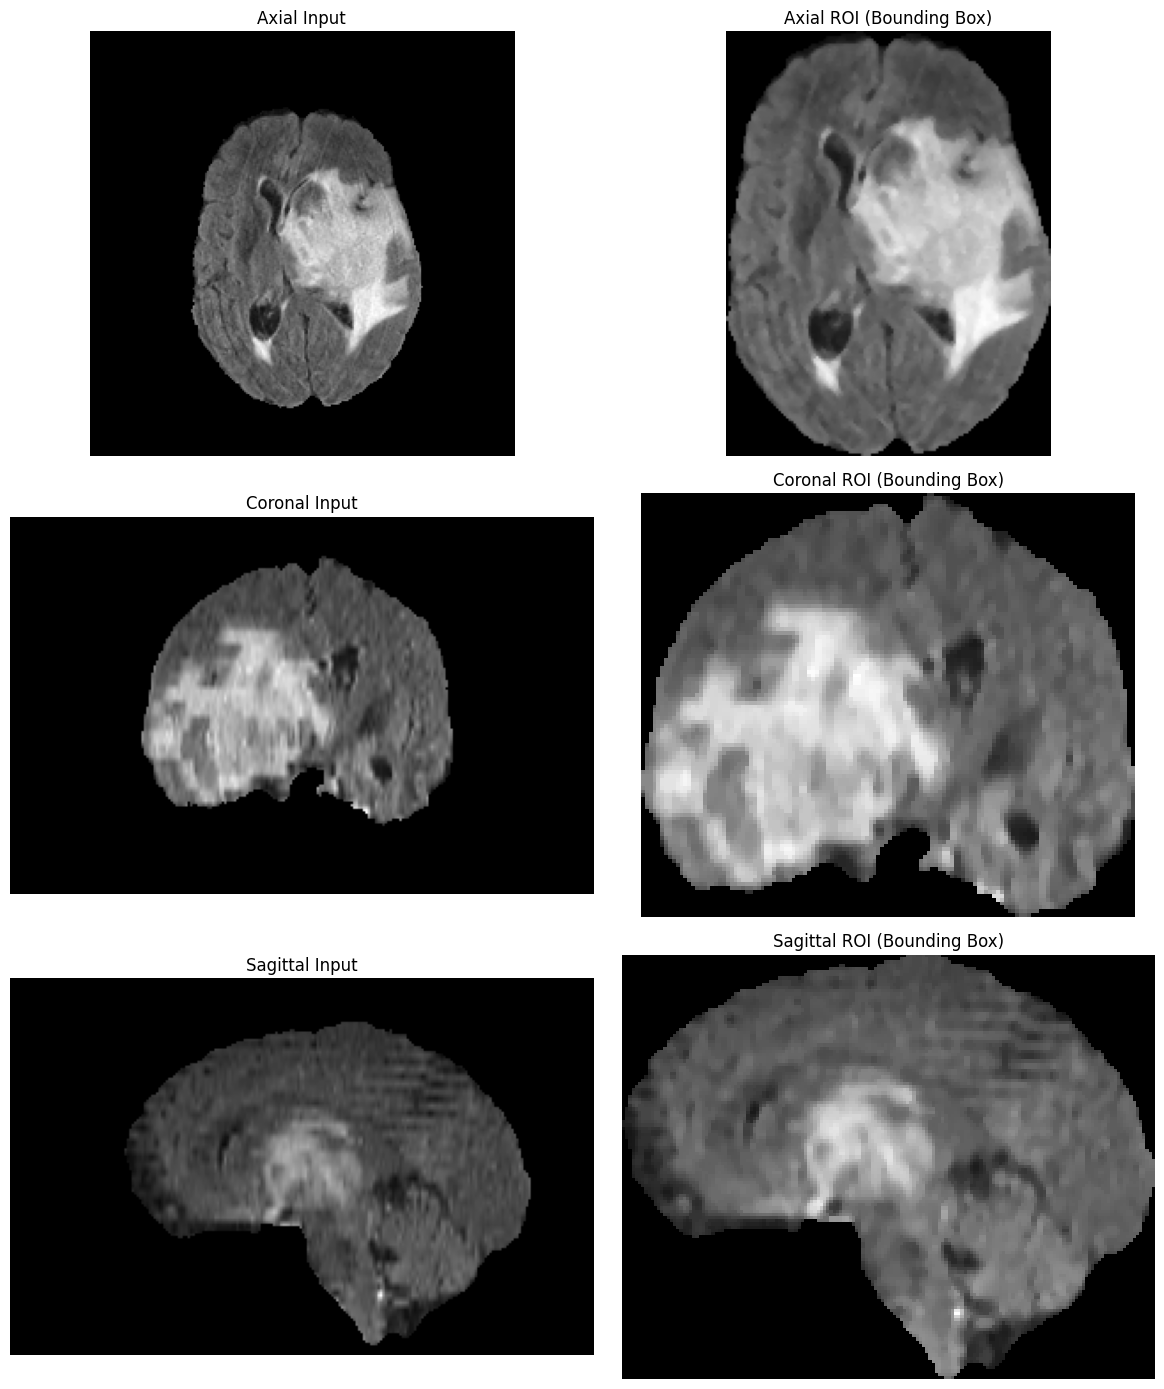

In [10]:
# Crop ROI cho coronal và sagittal, so sánh kích thước
from roi_extract import ROI
import numpy as np
import matplotlib.pyplot as plt

arr = images['FLAIR']
axial_idx = arr.shape[2] // 2
coronal_idx = arr.shape[1] // 2
sagittal_idx = arr.shape[0] // 2

# Axial
axial_img = np.rot90(arr[:, :, axial_idx].T, k=2)
roi_axial = ROI(axial_img)
# Coronal
coronal_img = np.rot90(arr[:, coronal_idx, :].T, k=4)
roi_coronal = ROI(coronal_img)
# Sagittal
sagittal_img = np.rot90(arr[sagittal_idx, :, :].T, k=4)
roi_sagittal = ROI(sagittal_img)

fig, axes = plt.subplots(3, 2, figsize=(12, 14))
# Axial
axes[0, 0].imshow(axial_img, cmap='gray', origin='lower')
axes[0, 0].set_title('Axial Input')
axes[0, 0].axis('off')
axes[0, 1].imshow(roi_axial.roi, cmap='gray', origin='lower')
axes[0, 1].set_title('Axial ROI (Bounding Box)')
axes[0, 1].axis('off')
# Coronal
axes[1, 0].imshow(coronal_img, cmap='gray', origin='lower')
axes[1, 0].set_title('Coronal Input')
axes[1, 0].axis('off')
axes[1, 1].imshow(roi_coronal.roi, cmap='gray', origin='lower')
axes[1, 1].set_title('Coronal ROI (Bounding Box)')
axes[1, 1].axis('off')
# Sagittal
axes[2, 0].imshow(sagittal_img, cmap='gray', origin='lower')
axes[2, 0].set_title('Sagittal Input')
axes[2, 0].axis('off')
axes[2, 1].imshow(roi_sagittal.roi, cmap='gray', origin='lower')
axes[2, 1].set_title('Sagittal ROI (Bounding Box)')
axes[2, 1].axis('off')
plt.tight_layout()
plt.show()

# Thông tin kích thước
original_shape = arr.shape
cropped_shape = (
    roi_axial.roi.shape[0], roi_coronal.roi.shape[0], roi_sagittal.roi.shape[0]
)
original_voxels = np.prod(original_shape)
cropped_voxels = roi_axial.roi.size  

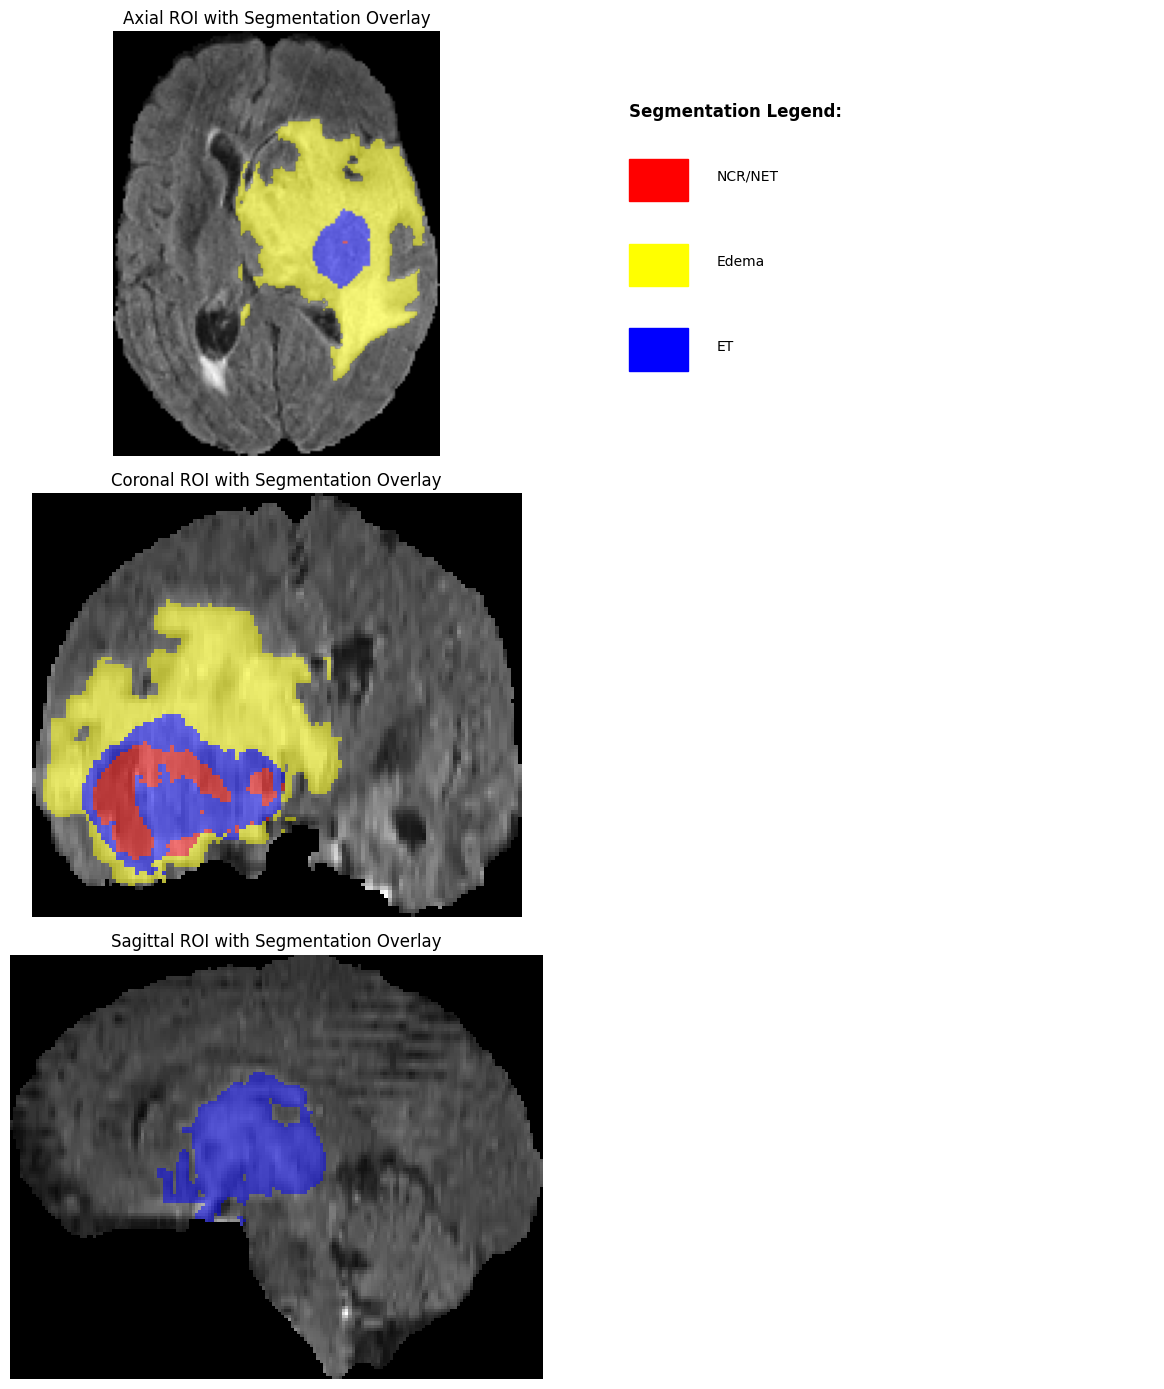

In [11]:
import matplotlib.patches as patches

cmap_seg = ListedColormap(['none', 'red', 'yellow', 'blue'])  # 0: transparent, 1: red (NCR), 2: yellow (ED), 4: blue (ET)

fig, axes = plt.subplots(3, 2, figsize=(12, 14))

# Axial
seg_axial = seg_arr[:, :, axial_idx]
seg_axial_rot = np.rot90(seg_axial.T, k=2)

non_zero = np.where(axial_img > 0)
if len(non_zero[0]) > 0:
    y_min, y_max = non_zero[0].min(), non_zero[0].max()
    x_min, x_max = non_zero[1].min(), non_zero[1].max()
    roi_img = axial_img[y_min:y_max+1, x_min:x_max+1]
    seg_cropped = seg_axial_rot[y_min:y_max+1, x_min:x_max+1]
    axes[0, 0].imshow(roi_img, cmap='gray', origin='lower')
    axes[0, 0].imshow(seg_cropped, cmap=cmap_seg, alpha=0.5, origin='lower')
else:
    axes[0, 0].imshow(roi_axial.roi, cmap='gray', origin='lower')
axes[0, 0].set_title('Axial ROI with Segmentation Overlay')
axes[0, 0].axis('off')

# Coronal
seg_coronal = seg_arr[:, coronal_idx, :]
seg_coronal_rot = np.rot90(seg_coronal.T, k=4)
non_zero = np.where(coronal_img > 0)
if len(non_zero[0]) > 0:
    y_min, y_max = non_zero[0].min(), non_zero[0].max()
    x_min, x_max = non_zero[1].min(), non_zero[1].max()
    roi_img = coronal_img[y_min:y_max+1, x_min:x_max+1]
    seg_cropped = seg_coronal_rot[y_min:y_max+1, x_min:x_max+1]
    axes[1, 0].imshow(roi_img, cmap='gray', origin='lower')
    axes[1, 0].imshow(seg_cropped, cmap=cmap_seg, alpha=0.5, origin='lower')
else:
    axes[1, 0].imshow(roi_coronal.roi, cmap='gray', origin='lower')
axes[1, 0].set_title('Coronal ROI with Segmentation Overlay')
axes[1, 0].axis('off')

# Sagittal
seg_sagittal = seg_arr[sagittal_idx, :, :]
seg_sagittal_rot = np.rot90(seg_sagittal.T, k=4)
non_zero = np.where(sagittal_img > 0)
if len(non_zero[0]) > 0:
    y_min, y_max = non_zero[0].min(), non_zero[0].max()
    x_min, x_max = non_zero[1].min(), non_zero[1].max()
    roi_img = sagittal_img[y_min:y_max+1, x_min:x_max+1]
    seg_cropped = seg_sagittal_rot[y_min:y_max+1, x_min:x_max+1]
    axes[2, 0].imshow(roi_img, cmap='gray', origin='lower')
    axes[2, 0].imshow(seg_cropped, cmap=cmap_seg, alpha=0.5, origin='lower')
else:
    axes[2, 0].imshow(roi_sagittal.roi, cmap='gray', origin='lower')
axes[2, 0].set_title('Sagittal ROI with Segmentation Overlay')
axes[2, 0].axis('off')

# Legend
axes[0, 1].axis('off')
axes[0, 1].text(0.1, 0.8, 'Segmentation Legend:', fontsize=12, fontweight='bold')
axes[0, 1].add_patch(patches.Rectangle((0.1, 0.6), 0.1, 0.1, color='red'))
axes[0, 1].text(0.25, 0.65, 'NCR/NET', fontsize=10)
axes[0, 1].add_patch(patches.Rectangle((0.1, 0.4), 0.1, 0.1, color='yellow'))
axes[0, 1].text(0.25, 0.45, 'Edema', fontsize=10)
axes[0, 1].add_patch(patches.Rectangle((0.1, 0.2), 0.1, 0.1, color='blue'))
axes[0, 1].text(0.25, 0.25, 'ET', fontsize=10)

axes[1, 1].axis('off')
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Tính kích thước vật lý thực tế của não sau khi crop
header = nib.load(modalities['FLAIR']).header
voxel_spacing = header.get_zooms()  # (X, Y, Z) mm

# Crop bounding box 3D cho toàn bộ volume
flair_data = images['FLAIR']
non_zero_mask = flair_data > 0
x_indices = np.where(np.any(non_zero_mask, axis=(1, 2)))[0]
y_indices = np.where(np.any(non_zero_mask, axis=(0, 2)))[0]
z_indices = np.where(np.any(non_zero_mask, axis=(0, 1)))[0]
x_min, x_max = x_indices[0], x_indices[-1]
y_min, y_max = y_indices[0], y_indices[-1]
z_min, z_max = z_indices[0], z_indices[-1]

flair_cropped = flair_data[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]

# Kích thước vật lý thực tế
brain_width = flair_cropped.shape[0] * voxel_spacing[0]
brain_height = flair_cropped.shape[1] * voxel_spacing[1]
brain_depth = flair_cropped.shape[2] * voxel_spacing[2]

print("\nKích thước não sau khi crop bounding box 3D:")
print(f"  Trục X (Chiều rộng / Trái - Phải): {brain_width:.1f} mm ({brain_width/10:.1f} cm)")
print(f"  Trục Y (Chiều dài / Trước - Sau): {brain_height:.1f} mm ({brain_height/10:.1f} cm)")
print(f"  Trục Z (Chiều cao / Trên - Dưới): {brain_depth:.1f} mm ({brain_depth/10:.1f} cm)")
print(f"  Thể tích: {(brain_width * brain_height * brain_depth)/1000:.1f} cm³")

# Tính thể tích khối u từ segmentation
if seg_arr is not None:
    voxel_volume = abs(np.linalg.det(nib.load(modalities['FLAIR']).affine[:3, :3]))  # mm³ per voxel

    # Thể tích vùng tổn thương toàn bộ (whole tumor: NCR + Edema + ET)
    whole_tumor_voxels = np.sum((seg_arr == 1) | (seg_arr == 2) | (seg_arr == 4))
    whole_tumor_volume = whole_tumor_voxels * voxel_volume / 1000  # cm³

    # Thể tích lõi u (tumor core: NCR + ET)
    core_voxels = np.sum((seg_arr == 1) | (seg_arr == 4))
    core_volume = core_voxels * voxel_volume / 1000  # cm³

    # Thể tích u tăng cường (Enhancing Tumor)
    et_voxels = np.sum(seg_arr == 4)
    et_volume = et_voxels * voxel_volume / 1000  # cm³

    # Thể tích phù nề (Edema)
    edema_voxels = np.sum(seg_arr == 2)
    edema_volume = edema_voxels * voxel_volume / 1000  # cm³

    print("\nThể tích khối u từ segmentation:")
    print(f"  Vùng tổn thương toàn bộ (Whole Tumor): {whole_tumor_volume:.1f} cm³ ({whole_tumor_voxels:,} voxels)")
    print(f"  Lõi u (Tumor Core): {core_volume:.1f} cm³ ({core_voxels:,} voxels)")
    print(f"  U tăng cường (Enhancing Tumor): {et_volume:.1f} cm³ ({et_voxels:,} voxels)")
    print(f"  Phù nề (Edema): {edema_volume:.1f} cm³ ({edema_voxels:,} voxels)")

    # Tính kích thước vật lý của khối u (Whole Tumor)
    tumor_mask = (seg_arr == 1) | (seg_arr == 2) | (seg_arr == 4)
    x_indices_tumor = np.where(np.any(tumor_mask, axis=(1, 2)))[0]
    y_indices_tumor = np.where(np.any(tumor_mask, axis=(0, 2)))[0]
    z_indices_tumor = np.where(np.any(tumor_mask, axis=(0, 1)))[0]

    if len(x_indices_tumor) > 0 and len(y_indices_tumor) > 0 and len(z_indices_tumor) > 0:
        x_min_t, x_max_t = x_indices_tumor[0], x_indices_tumor[-1]
        y_min_t, y_max_t = y_indices_tumor[0], y_indices_tumor[-1]
        z_min_t, z_max_t = z_indices_tumor[0], z_indices_tumor[-1]

        tumor_width = (x_max_t - x_min_t + 1) * voxel_spacing[0]
        tumor_height = (y_max_t - y_min_t + 1) * voxel_spacing[1]
        tumor_depth = (z_max_t - z_min_t + 1) * voxel_spacing[2]

        print("\nKích thước khối u (Whole Tumor):")
        print(f"  Trục X (Chiều rộng): {tumor_width:.1f} mm ({tumor_width/10:.1f} cm)")
        print(f"  Trục Y (Chiều dài): {tumor_height:.1f} mm ({tumor_height/10:.1f} cm)")
        print(f"  Trục Z (Chiều cao): {tumor_depth:.1f} mm ({tumor_depth/10:.1f} cm)")
    else:
        print("\nKhông tìm thấy khối u trong segmentation.")


Kích thước não sau khi crop bounding box 3D:
  Trục X (Chiều rộng / Trái - Phải): 137.0 mm (13.7 cm)
  Trục Y (Chiều dài / Trước - Sau): 173.0 mm (17.3 cm)
  Trục Z (Chiều cao / Trên - Dưới): 135.0 mm (13.5 cm)
  Thể tích: 3199.6 cm³

Thể tích khối u từ segmentation:
  Vùng tổn thương toàn bộ (Whole Tumor): 212.0 cm³ (211,979 voxels)
  Lõi u (Tumor Core): 43.2 cm³ (43,185 voxels)
  U tăng cường (Enhancing Tumor): 27.7 cm³ (27,742 voxels)
  Phù nề (Edema): 168.8 cm³ (168,794 voxels)

Kích thước khối u (Whole Tumor):
  Trục X (Chiều rộng): 93.0 mm (9.3 cm)
  Trục Y (Chiều dài): 110.0 mm (11.0 cm)
  Trục Z (Chiều cao): 83.0 mm (8.3 cm)
